# ENV717 L18 - UNIT COMMITMENT PROBLEM with RAMP-FEASIBLE RESERVES

### Data from Handout Lesson 8 - 9 - 10
##### Constraints Included:  Pmin, Pmax, Demand Balance constraints, On-Off logic constraints, No simultaneous Start-up and Shut-down, Ramp, RAMP FEASIBLE reserves
#### Costs included: Fixed, variable, startUp and shutDown
#### Work on your own to include min up-time and min-down time constraints

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyomo.environ import *
opt = SolverFactory('cplex') #The CPLEX license is free for students - In Colab you can use CBC

In [2]:
#Read data
df_genData=pd.read_excel(io="UCData.xlsx",sheet_name="GeneratorsData",skiprows=1) #read data from generators tab and skip the first row
df_demandData=pd.read_excel(io="UCData.xlsx",sheet_name="DemandData",skiprows=1) #read data from demand tab and skip the first row
df_reservesData=pd.read_excel(io="UCData.xlsx",sheet_name="ReservesData",skiprows=1) #read data from reserves tab and skip the first row

In [3]:
#define the size of the sets
NumGen=len(df_genData)
NumPeriods=len(df_demandData)
T=len(df_demandData)
print("We read data for", NumGen, "power generating units")
print("We read data for", T, "time periods")

We read data for 2 power generating units
We read data for 24 time periods


In [4]:
#Define Indexes
N=np.array([n for n in range(0,NumGen)]) #This array has 2 components, but the index starts at zero
T=np.array([t for t in range(0,NumPeriods)])
T2=np.array([t2 for t2 in range(1,NumPeriods)])#Need this t2 index to write the ramp-up constraints

In [5]:
print(T2)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


In [6]:
df_genData.columns

Index(['FixedCost', 'SDCost', 'SUCost', 'VarCost', 'MaxGen', 'MinGen',
       'RampDown', 'RampSD', 'RampSU', 'RampUp', 'MinUpTime', 'MinDownTime',
       'ReqUp', 'ReqDown', 'InitialStatus', 'InitialGen'],
      dtype='object')

In [7]:
##Declare the generator's parameters and assign them the data we read before
FixCost=df_genData.loc[:,'FixedCost'].to_numpy()
SDCost=df_genData.loc[:,'SDCost'].to_numpy()
SUCost=df_genData.loc[:,'SUCost'].to_numpy()
VarCost=df_genData.loc[:,'VarCost'].to_numpy()
PMax=df_genData.loc[:,'MaxGen'].to_numpy()
PMin=df_genData.loc[:,'MinGen'].to_numpy()
UpRamp=df_genData.loc[:,'RampUp'].to_numpy()
DownRamp=df_genData.loc[:,'RampDown'].to_numpy()
SURamp=df_genData.loc[:,'RampSU'].to_numpy()
SDRamp=df_genData.loc[:,'RampSD'].to_numpy()
MinUpTime=df_genData.loc[:,'MinUpTime'].to_numpy()
MinDownTime=df_genData.loc[:,'MinDownTime'].to_numpy()
ReqOn=df_genData.loc[:,'ReqUp'].to_numpy()
ReqOff=df_genData.loc[:,'ReqDown'].to_numpy()
InitialOnOff=df_genData.loc[:,'InitialStatus'].to_numpy()
InitialGen=df_genData.loc[:,'InitialGen'].to_numpy()
##Declare the system's parameters and assign them the data we read
Demand=df_demandData.loc[:,'Demand'].to_numpy()
ReqReserves=df_reservesData.loc[:,'Reserves'].to_numpy()

In [8]:
#UC MODEL
def Unit_Commitment():
    m=ConcreteModel()
    m.N=Set(initialize=N)
    m.T=Set(initialize=T)
    m.T2=Set(initialize=T2)
    m.p=Var(m.N, m.T, bounds = (0,3500))#This is power generation
    m.pbar=Var(m.N,m.T, bounds=(0,3500))#This is feasible/available power generation 
    m.u=Var(m.N, m.T, domain=Binary)
    m.y=Var(m.N, m.T, domain=Binary)
    m.z=Var(m.N, m.T, domain=Binary)
    m.system_cost=Objective(expr=sum(m.p[n,t]*VarCost[n]+m.u[n,t]*FixCost[n]+m.y[n,t]*SUCost[n]+m.z[n,t]*SDCost[n] for n in m.N for t in m.T), sense=minimize)
    m.DemandConstraint=Constraint(m.T, rule=lambda m, t: sum(m.p[n,t] for n in N) == Demand[t])
   # m.Reserves=Constraint(m.T, rule=lambda m, t: sum(m.u[n,t]*PMax[n] for n in N)>= Demand[t]+ReqReserves[t])
    m.RampFeasibleReserves=Constraint(m.T, rule=lambda m, t: sum(m.pbar[n,t] for n in N) >= Demand[t]+ReqReserves[t])#replaces the reserves constraint
    m.MinPowerPbar=Constraint(m.N, m.T, rule=lambda m, n, t: PMin[n]*m.u[n,t] <= m.pbar[n,t])#for pbar
    m.MaxPowerPbar=Constraint(m.N, m.T, rule=lambda m, n, t: PMax[n]*m.u[n,t] >= m.pbar[n,t])#for pbar
    m.PlessPbar=Constraint(m.N, m.T, rule=lambda m, n, t: m.p[n,t]<=m.pbar[n,t] )#p must be less than pbar
    m.MinPower=Constraint(m.N, m.T, rule=lambda m, n, t: PMin[n]*m.u[n,t] <= m.p[n,t])
    m.RampUpt1Pbar=Constraint(m.N, rule=lambda m, n: m.pbar[n,0]-InitialGen[n]<=InitialOnOff[n]*UpRamp[n]+m.y[n,0]*SURamp[n])#for pbar
    m.RampUpPbar=Constraint(m.N, m.T2, rule=lambda m, n, t2: m.pbar[n,t2]-m.p[n,t2-1]<=m.u[n,t2-1]*UpRamp[n]+m.y[n,t2]*SURamp[n])#Links pbar & p
    m.RampDownt1Pbar=Constraint(m.N, rule=lambda m, n: InitialGen[n]-m.pbar[n,0]<=m.u[n,0]*DownRamp[n]+m.z[n,0]*SDRamp[n])#for pbar
    m.RampDownPbar=Constraint(m.N, m.T2, rule=lambda m, n, t2: m.p[n,t2-1]-m.pbar[n,t2]<=m.u[n,t2]*DownRamp[n]+m.z[n,t2]*SDRamp[n])#Links pbar & p
    m.RampDownt1=Constraint(m.N, rule=lambda m, n: InitialGen[n]-m.p[n,0]<=m.u[n,0]*DownRamp[n]+m.z[n,0]*SDRamp[n])
    m.RampDown=Constraint(m.N, m.T2, rule=lambda m, n, t2: m.p[n,t2-1]-m.p[n,t2]<=m.u[n,t2]*DownRamp[n]+m.z[n,t2]*SDRamp[n])#Links
    m.OnOfflogict1=Constraint(m.N, rule=lambda m, n: m.y[n,0]-m.z[n,0]==m.u[n,0]-InitialOnOff[n])
    m.OnOfflogic=Constraint(m.N, m.T2, rule=lambda m, n, t2: m.y[n,t2]-m.z[n,t2]==m.u[n,t2]-m.u[n,t2-1])   
    m.NoSuSD=Constraint(m.N,m.T, rule=lambda m,n,t: m.y[n,t]+m.z[n,t]<=1) 
    return m

In [9]:
m=Unit_Commitment()
SolverFactory('cplex').solve(m).write() # Instead of this line, write "opt.solve(m)" if model's details are not important

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: tmpj61_dzos
  Lower bound: 191194.0
  Upper bound: 191194.0
  Number of objectives: 1
  Number of constraints: 481
  Number of variables: 241
  Number of nonzeros: 1335
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: 0.02
  Termination condition: optimal
  Termination message: MIP - Integer optimal solution\x3a Objective = 1.9119400000e+05
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.9958920478820801
# --

In [10]:
print('SOLUTION')
print('The total system cost is = $',m.system_cost())
print('Commitment and Generation')
for n in N:
    for t in T:
        print("n = {0:2d}  t = {1:2d}   {2} {3:.0f} {4} {5:.0f} {6} {7:.0f} {8:.2f}".format(n, t, m.u[n,t], m.u[n,t](), m.y[n,t], m.y[n,t](), m.z[n,t], m.z[n,t](),m.p[n,t]()))

SOLUTION
The total system cost is = $ 191194.0
Commitment and Generation
n =  0  t =  0   u[0,0] 1 y[0,0] 0 z[0,0] 0 140.00
n =  0  t =  1   u[0,1] 1 y[0,1] 0 z[0,1] 0 170.00
n =  0  t =  2   u[0,2] 1 y[0,2] -0 z[0,2] -0 210.00
n =  0  t =  3   u[0,3] 1 y[0,3] -0 z[0,3] -0 220.00
n =  0  t =  4   u[0,4] 1 y[0,4] -0 z[0,4] -0 200.00
n =  0  t =  5   u[0,5] 1 y[0,5] -0 z[0,5] -0 210.00
n =  0  t =  6   u[0,6] 1 y[0,6] -0 z[0,6] -0 230.00
n =  0  t =  7   u[0,7] 1 y[0,7] -0 z[0,7] -0 270.00
n =  0  t =  8   u[0,8] 1 y[0,8] -0 z[0,8] -0 290.00
n =  0  t =  9   u[0,9] 1 y[0,9] -0 z[0,9] -0 300.00
n =  0  t = 10   u[0,10] 1 y[0,10] -0 z[0,10] -0 300.00
n =  0  t = 11   u[0,11] 1 y[0,11] -0 z[0,11] -0 300.00
n =  0  t = 12   u[0,12] 1 y[0,12] -0 z[0,12] -0 300.00
n =  0  t = 13   u[0,13] 1 y[0,13] -0 z[0,13] -0 300.00
n =  0  t = 14   u[0,14] 1 y[0,14] -0 z[0,14] -0 300.00
n =  0  t = 15   u[0,15] 1 y[0,15] -0 z[0,15] -0 300.00
n =  0  t = 16   u[0,16] 1 y[0,16] -0 z[0,16] -0 280.00
n =  0  t

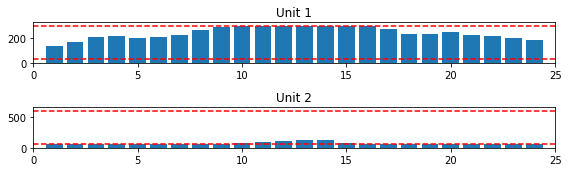

In [11]:
#Graph solution
fig, ax = plt.subplots(max(N)+1, 1, figsize=(8, 1.5*max(N)+1))
for n in N:
    ax[n].bar(T+1, [m.p[n,t]() for t in T])
    ax[n].set_xlim(0, max(T)+2)
    ax[n].set_ylim(0, 1.1*PMax[n])
    ax[n].plot(ax[n].get_xlim(), np.array([PMax[n], PMax[n]]), 'r--')
    ax[n].plot(ax[n].get_xlim(), np.array([PMin[n], PMin[n]]), 'r--')
    ax[n].set_title('Unit ' + str(n+1))
fig.tight_layout()